### __Import Libraries__

In [18]:
import os
import matplotlib.pyplot as plt
import cv2
import pydicom
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


### __remove warning__

In [20]:
#remove warnings
import warnings
warnings.filterwarnings('ignore')

### __Define Paths__

In [5]:
# Base dataset folder
base_dir = './Brain_Stroke_CT_Dataset'
print(os.listdir(base_dir))

# Classes
classes = ["normal", "Ischemia", "Bleeding"]

# We'll start with PNG images
png_folders = {cls: os.path.join(base_dir, cls, "png") for cls in classes}


['Bleeding', 'External_Test', 'Ischemia', 'Normal']


### __Load PNG Images and Display Samples__

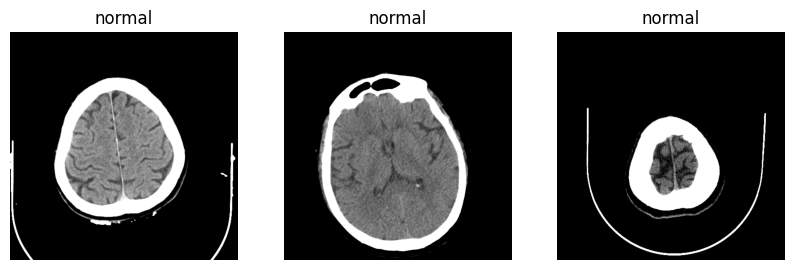

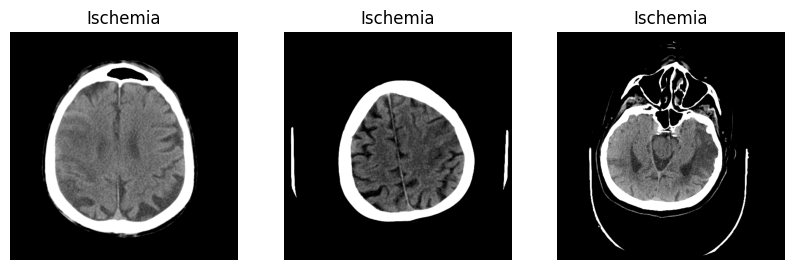

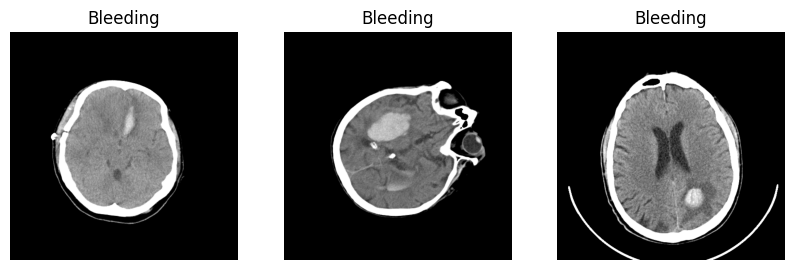

In [6]:
# Display 3 images per class
for cls in classes:
    folder = png_folders[cls]
    images = os.listdir(folder)[:3]  # first 3 images
    plt.figure(figsize=(10,3))
    
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # CT images are grayscale
        plt.subplot(1, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(cls)
        plt.axis('off')
    plt.show()


### __Load a DICOM Image__

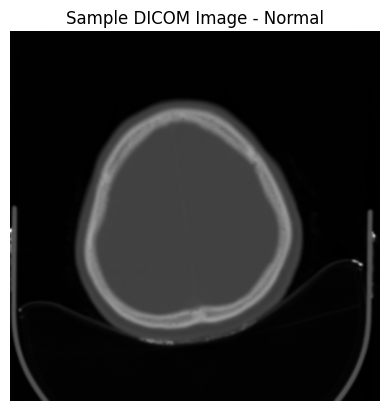

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 212
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.1.4.92942.30000020010604300728700000817
(0002,0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.30071.8
(0002,0013) Implementation Version Name         SH: 'fo-dicom 4.0.0'
(0002,0016) Source Application Entity Title     AE: 'TEKNOYPYZEKA'
-------------------------------------------------
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0018,0050) Slice Thickness                     DS: '5'
(0028,0002) Samples per Pixel                   US: 1
(0028,0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028,0010) Rows                                US: 51

In [7]:
# Pick a DICOM file from the normal folder
dicom_file = os.path.join(base_dir, "normal", "dicom", os.listdir(os.path.join(base_dir,"normal","dicom"))[0])

# Read DICOM
dcm = pydicom.dcmread(dicom_file)
image = dcm.pixel_array

# Display
plt.imshow(image, cmap='gray')
plt.title("Sample DICOM Image - Normal")
plt.axis('off')
plt.show()

# Print some metadata
print(dcm)

### __Define preprocessing parameters__


In [9]:
IMG_SIZE = 224   # standard input size for CNN
classes = ["normal", "Ischemia", "Bleeding"]

base_dir = './Brain_Stroke_CT_Dataset'
png_folders = {cls: os.path.join(base_dir, cls, "png") for cls in classes}


### __Load, resize, and normalize all images__

In [10]:
X = []   # images
y = []   # labels

for label, cls in enumerate(classes):
    folder = png_folders[cls]
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0     # normalize to [0,1]
            X.append(img)
            y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

print("Dataset shape:", X.shape, y.shape)

Dataset shape: (6650, 224, 224, 1) (6650,)


### __Split into train and test sets__

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Train shape: (5320, 224, 224, 1)
Validation shape: (1330, 224, 224, 1)


### __Visualize a few preprocessed images__

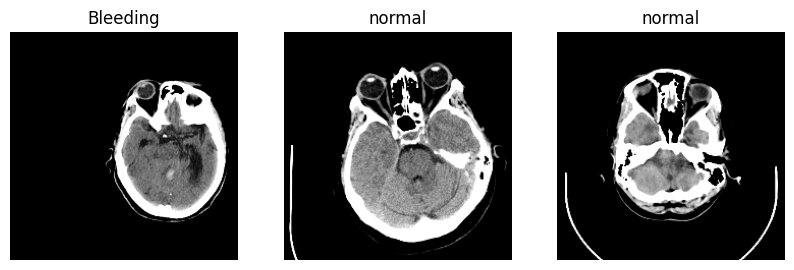

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(X_train[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(classes[y_train[i]])
    plt.axis('off')
plt.show()


### __Using Keras’ ImageDataGenerator__

In [14]:
# For training data
train_datagen = ImageDataGenerator(
    rotation_range=15,      # rotate ±15 degrees
    width_shift_range=0.1,  # shift horizontally by ±10%
    height_shift_range=0.1, # shift vertically by ±10%
    zoom_range=0.1,         # zoom in/out ±10%
    horizontal_flip=True,   # randomly flip horizontally
    vertical_flip=False,    # optional: brain images usually not flipped vertically
)

# For validation data: just rescale
val_datagen = ImageDataGenerator()

### __Create augmented generators__

In [15]:
batch_size = 32

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=batch_size
)


### __Visualize augmented images__

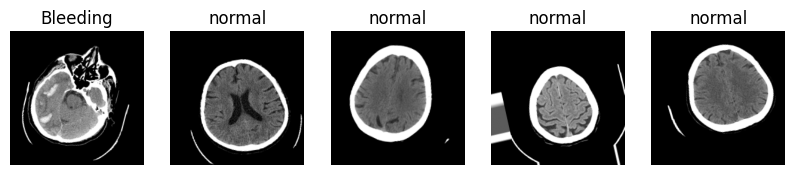

In [17]:
# Take one batch of augmented images
aug_images, aug_labels = next(train_generator)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(aug_images[i].reshape(224,224), cmap='gray')
    plt.title(classes[aug_labels[i]])
    plt.axis('off')
plt.show()


### __Build the CNN__

In [21]:
IMG_SIZE = 224
num_classes = 3  # Normal, Ischemia, Bleeding

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # 3 classes
])

### __Compile the model__

In [22]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # because labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,867 (84.86 MB)

 Trainable params: 22,244,867 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

### __Set training parameters__

In [24]:
epochs = 15
batch_size = 32

### __Train using the augmented data generator__

In [25]:
history = model.fit(
    train_generator,       # augmented training data
    validation_data=val_generator,  # validation data (not augmented)
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 172s 997ms/step - accuracy: 0.6615 - loss: 0.8691 - val_accuracy: 0.6677 - val_loss: 0.8310
Epoch 2/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 154s 921ms/step - accuracy: 0.6667 - loss: 0.8259 - val_accuracy: 0.6654 - val_loss: 0.7866
Epoch 3/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.6699 - loss: 0.8002 - val_accuracy: 0.6737 - val_loss: 0.7541
Epoch 4/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.6773 - loss: 0.7844 - val_accuracy: 0.6962 - val_loss: 0.7569
Epoch 5/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.6825 - loss: 0.7716 - val_accuracy: 0.6947 - val_loss: 0.7198
Epoch 6/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.6887 - loss: 0.7566 - val_accuracy: 0.7173 - val_loss: 0.7005
Epoch 7/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.6949 - loss: 0.7416 - val_accuracy: 0.7053 - val_loss: 0.7700
Epoch 8/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.7090 - loss: 0.7213 - va

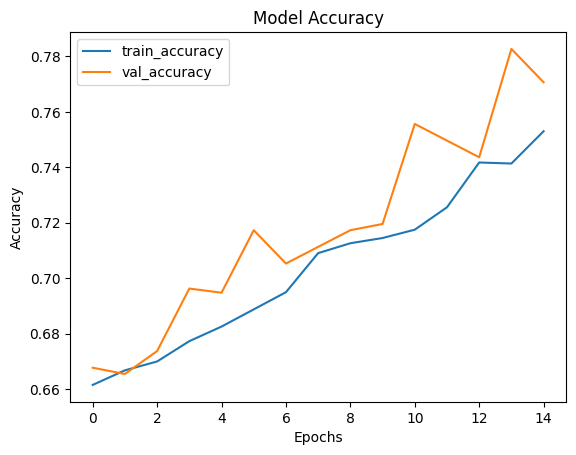

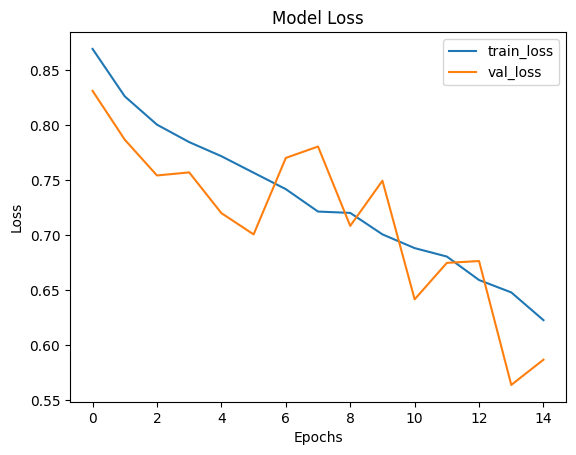

In [26]:
# Accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [27]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.7707 - loss: 0.5867
Validation Accuracy: 77.07%
